In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
spark = SparkSession.builder.appName('UKClimateChange').getOrCreate()

In [3]:
from io import StringIO
import itertools
import numpy as np
import pandas as pd
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(40,10))
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

<Figure size 2880x720 with 0 Axes>

In [4]:
%%time

def readFiles (feature):
    def process(tup):
        def convertTuple(tup): 
            str =  ''.join(tup) 
            return str

        # Driver code 
        str = convertTuple(tup[0:2]) 
        df = pd.read_csv(StringIO(str), header=None)

        # slicing the output and storing filename in "filename dataframe"
        filename = df[0:1]
        filename = filename.iloc[0][0].replace('txtncols         180','')
        filename = filename[-7:-1]

        # storing the content of file in "content dataframe"
        content = df[6:]

        counter = 0 
        allValues = 0
        
        # iterate through all the rows and columns of the file - better than for loop which took 40 mins
        modPandasDF=content.iloc[:,0].str.split(' ',expand=True).replace("-9999",float('NaN'))
        modPandasDF=modPandasDF.astype('float')
        modPandasDF=modPandasDF.values
        xDF=np.nanmean(modPandasDF)
        mean=np.nanmean(xDF)

        return filename, mean

    # daily grid data for rainfall
    if(feature=="rainfall" or feature=="maximum-temperature"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-daily/grid/"+feature+"/*"
    elif(feature=="sunshine" or feature=="snow-falling"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-monthly/"+feature+"/*"

    # Get rdd containing one record for each file.
    files_rdd = sc.wholeTextFiles(path, minPartitions=20)
    print(type(files_rdd))

    print('Number of records (months):', files_rdd.count())
    print('Number of partitions:', files_rdd.getNumPartitions())

    # map lines to n_words
    records = files_rdd.map(lambda n : process(n))

    # collect the RDD to a list
    llist = records.collect()

    # two arrays
    values = []
    months = []

    # store the filename in months array and its corrosponding value(mean) in values array
    for line in llist:
        values.append(line[1])
        months.append(line[0])

    # converting arrays to dataframes
    valuesdf = pd.DataFrame({'Hours':values[:]})
    yearmonthdf = pd.DataFrame({'YearMonth':months[:]})

    # merging two dataframes into one
    finaldf = pd.merge(yearmonthdf, valuesdf, left_index=True, right_index=True)

    # sort the index
    finaldf = finaldf.sort_values('YearMonth')

    # converting first column to integer format
    finaldf['YearMonth'] = finaldf['YearMonth'].astype('int')

    # converting first column from integer to datetime format
    finaldf['YearMonth'] = pd.to_datetime(finaldf['YearMonth'].astype(str), format='%Y%m')

    # extracting year and month 
    finaldf['Year'] = finaldf['YearMonth'].dt.year
    finaldf['Month'] = finaldf['YearMonth'].dt.month

    print(finaldf.head())
    
    return finaldf

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.96 µs


<class 'pyspark.rdd.RDD'>
Number of records (months): 1056
Number of partitions: 20
     YearMonth       Hours  Year  Month
742 1929-01-01   40.043334  1929      1
689 1929-02-01   51.755135  1929      2
265 1929-03-01  169.522647  1929      3
371 1929-04-01  154.340405  1929      4
636 1929-05-01  212.116798  1929      5


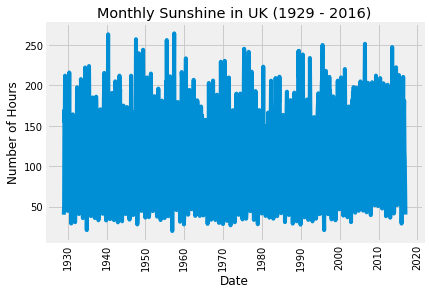

CPU times: user 205 ms, sys: 9.25 ms, total: 214 ms
Wall time: 14 s


In [5]:
%%time

finaldf = readFiles("sunshine")

# general raw plot for a feature
plt.plot(finaldf.YearMonth, finaldf.Hours)
plt.title('Monthly Sunshine in UK (1929 - 2016)')
plt.xlabel('Date')
plt.ylabel('Number of Hours')
plt.xticks(rotation='vertical')
plt.show()

In [6]:
z=pd.DataFrame(finaldf['YearMonth'])
z.insert(1,'Data',finaldf['Hours'])
z.to_csv('ASDI1.csv', index=False)

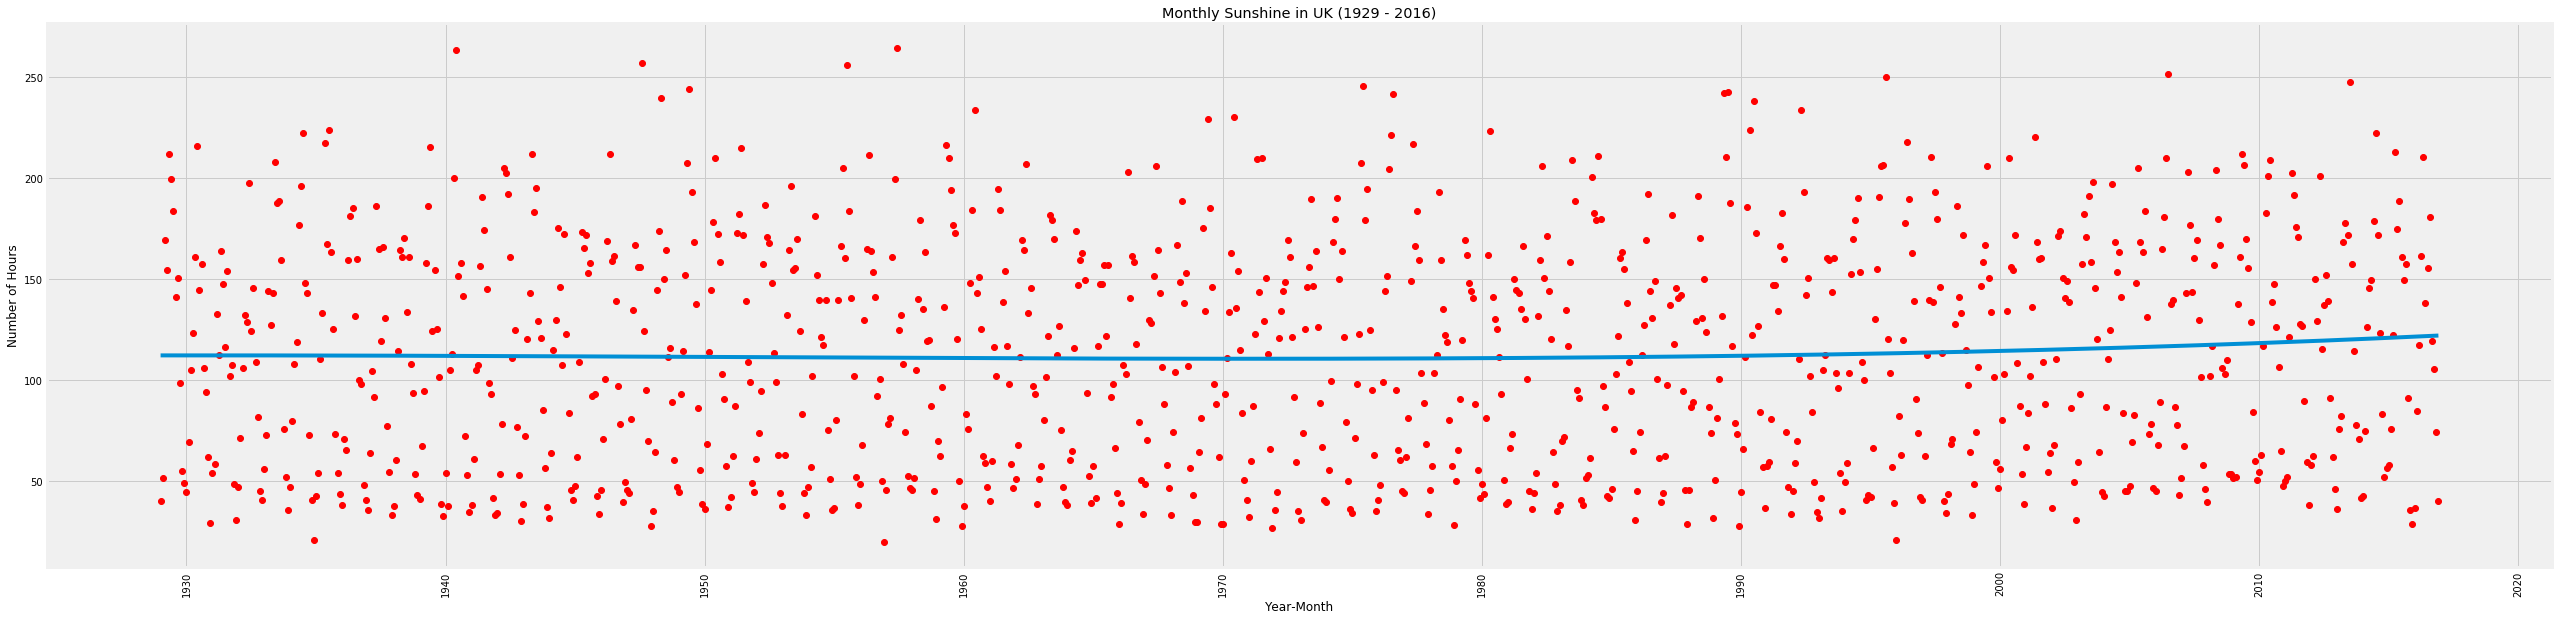

In [21]:
# BEST LINE FIT to look for any trend in data if present
y_values = finaldf['Hours']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(finaldf.loc[:, "Hours"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Monthly Sunshine in UK (1929 - 2016)')
plt.ylabel('Number of Hours')
plt.xticks(rotation='vertical')
plt.plot(finaldf.loc[:, "YearMonth"], finaldf.loc[:,"Hours"], "ro")
plt.plot(finaldf.loc[:, "YearMonth"], y_hat)
y=pd.DataFrame(y_hat)
y.insert(1,'Year',finaldf['YearMonth'])
y.to_csv('ASDI2.csv', index=False)

     YearMonth       Hours  Year  Month
742 1929-01-01   40.043334  1929      1
689 1929-02-01   51.755135  1929      2
265 1929-03-01  169.522647  1929      3
371 1929-04-01  154.340405  1929      4
636 1929-05-01  212.116798  1929      5


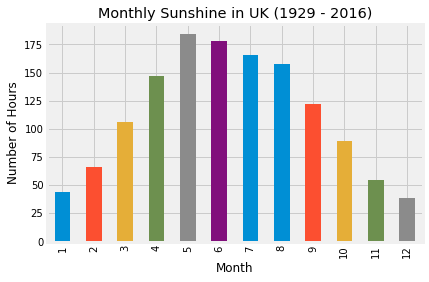

In [8]:
# creating a backup(tempdf) of finaldf
tempdf = finaldf
print(tempdf.head())

# plotting sunshine on monthly basis
plt.xlabel('Months')
plt.title('Monthly Sunshine in UK (1929 - 2016)')
plt.ylabel('Number of Hours')
tempdf.groupby('Month')['Hours'].mean().plot.bar()

   Year        Hours
0  1929  1505.845478
1  1930  1313.805282
2  1931  1229.343048
3  1932  1230.425610
4  1933  1451.744571
    Year        Hours
83  2012  1344.218543
84  2013  1422.533173
85  2014  1427.660452
86  2015  1456.783395
87  2016  1426.852569
Year       int64
Hours    float64
dtype: object


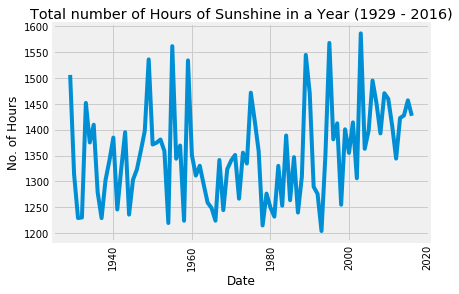

In [23]:
tempnewdf = tempdf.groupby(['Year'])['Hours'].agg('sum').reset_index()
print(tempnewdf.head())
print(tempnewdf.tail())
print(tempnewdf.dtypes)
plt.plot(tempnewdf.Year, tempnewdf.Hours)
plt.title('Total number of Hours of Sunshine in a Year (1929 - 2016)')
plt.xlabel('Date')
plt.ylabel('No. of Hours')
plt.xticks(rotation='vertical') 
z=pd.DataFrame(tempnewdf['Year'])
z.insert(1,'Data',tempnewdf['Hours'])
z.to_csv('ASDI3.csv', index=False)

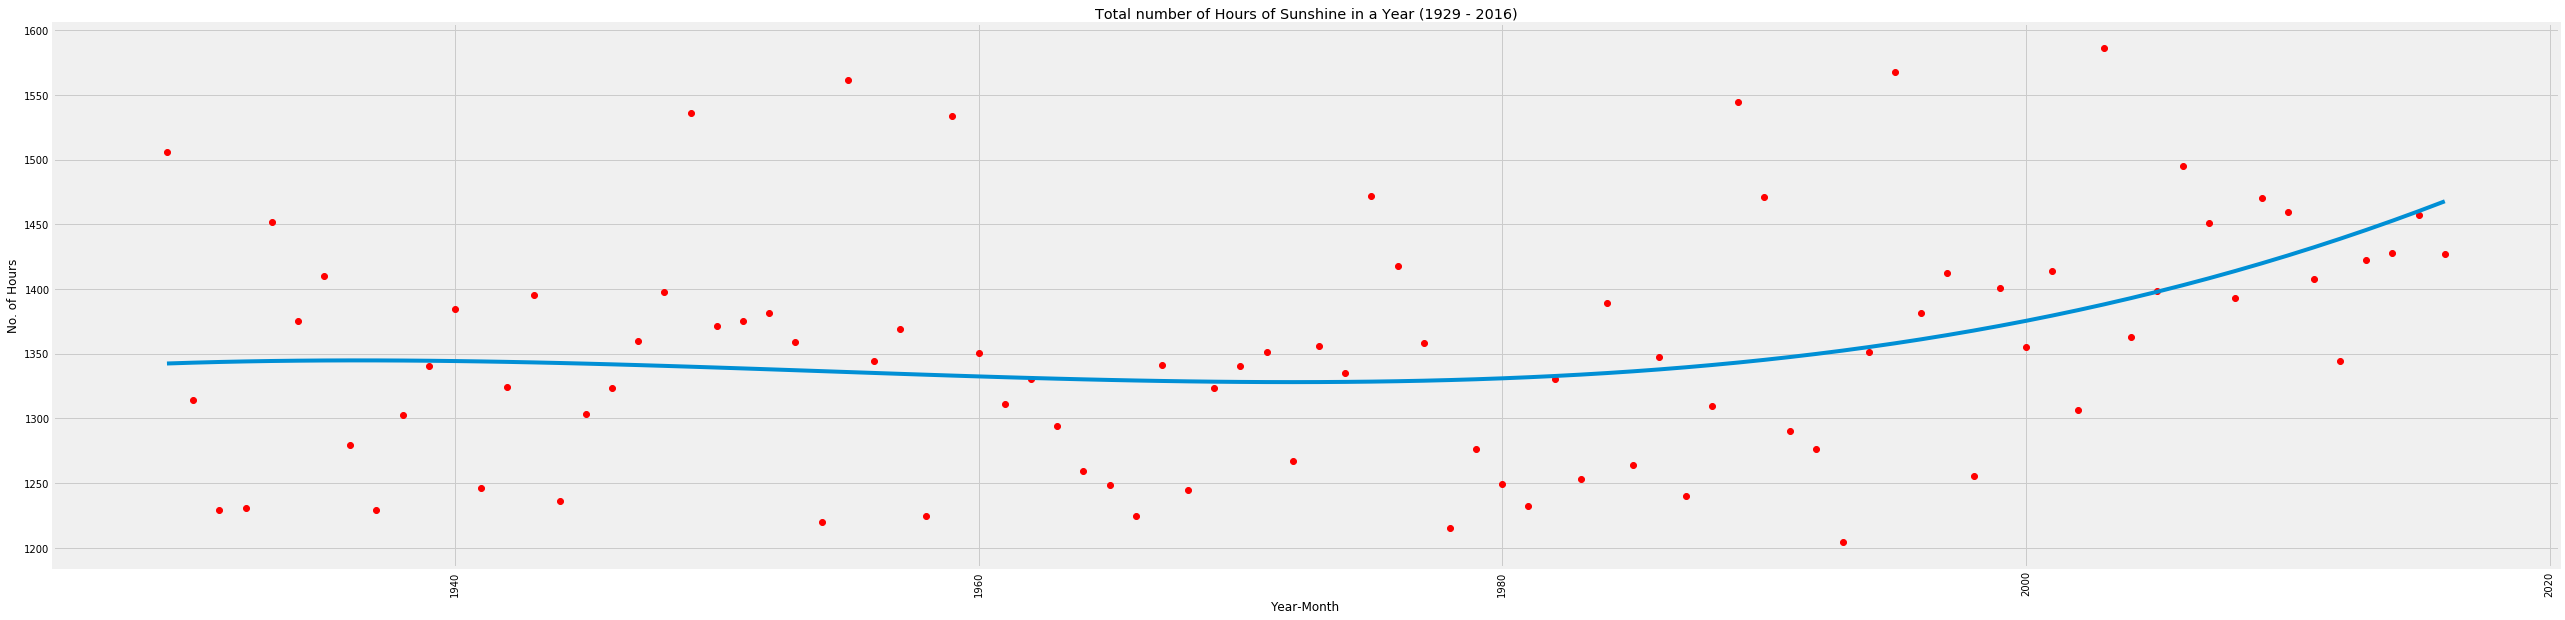

In [24]:
# BEST LINE FIT - the slope of this plot is better (increasing/decreasing) than the previous one
y_values = tempnewdf['Hours']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(tempnewdf.loc[:, "Hours"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)

fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Total number of Hours of Sunshine in a Year (1929 - 2016)')
plt.ylabel('No. of Hours')
plt.xticks(rotation='vertical')
plt.plot(tempnewdf.loc[:, "Year"], tempnewdf.loc[:,"Hours"], "ro")
plt.plot(tempnewdf.loc[:, "Year"], y_hat)
z=pd.DataFrame(y_hat)
z.insert(1,'Year',tempnewdf['Year'])
z.to_csv('ASDI4.csv', index=False)

In [11]:
tempnewdf.to_csv('SunshineIncrement.csv', index=False)

In [12]:
df = pd.read_csv('SunshineIncrement.csv', index_col='Year')
df.index = pd.to_datetime(df.index, format='%Y')
print(df.head())
print(df.dtypes)

                  Hours
Year                   
1929-01-01  1505.845478
1930-01-01  1313.805282
1931-01-01  1229.343048
1932-01-01  1230.425610
1933-01-01  1451.744571
Hours    float64
dtype: object


In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
# goal here is to use a “grid search” to find the optimal set of parameters(p, d, q) that yields the best performance for our model.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1503.7705861298252
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1218.5136743080056
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:941.6511364162352
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:767.1516575938075
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:958.9859309242132
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:911.2259414319748
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:789.4211515630482
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:769.0785666450769
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1388.675726305465
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1132.9812160294039
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:930.9222691847864
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:754.4660561516446
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:960.1240219372206
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:899.558929625967
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:788.4121061387093
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:756.4617119625507
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1062.4595122746498
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:919.5968853241402
ARIMA(0

In [15]:
# ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:733.5509578064065

# the above AIC (Akaike Information Critera) value is the lowest of all, so we should consider its corrosponding values as the optimal

# fitting the arima model
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8506      0.085    -10.007      0.000      -1.017      -0.684
ma.S.L12      -1.0001      0.158     -6.331      0.000      -1.310      -0.690
sigma2      6929.6243   2.28e-05   3.04e+08      0.000    6929.624    6929.624


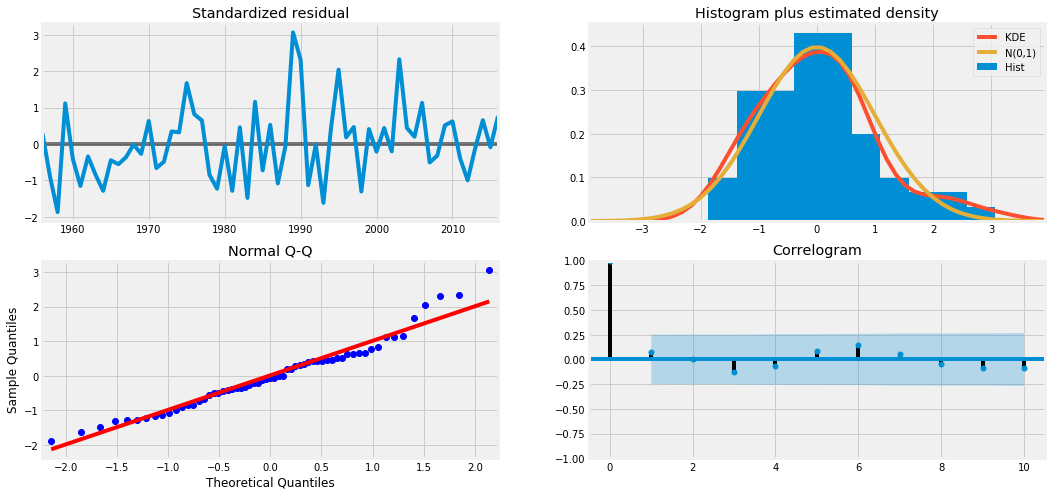

In [16]:
# model diagnostics to investigate any unusual behavior

results.plot_diagnostics(figsize=(16, 8))
plt.show()

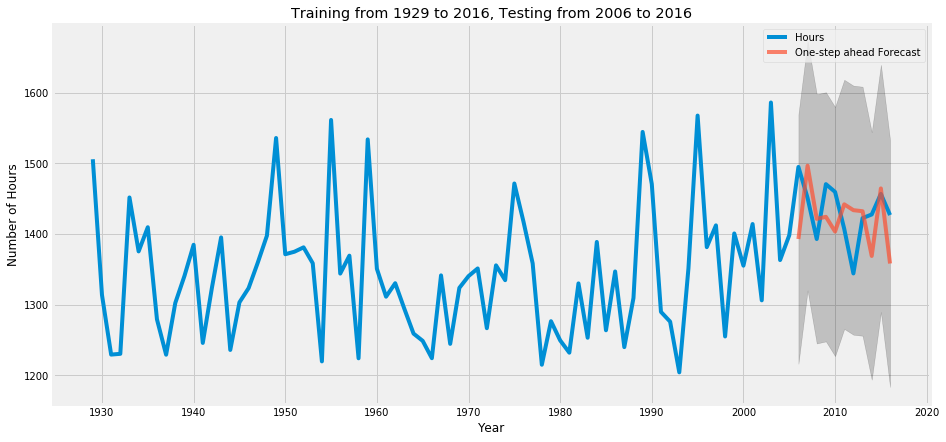

In [17]:
# validating forecasts from 2006-01-01 to the end date 2016-12-01

pred = results.get_prediction(start=pd.to_datetime('2006-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1929':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1929 to 2016, Testing from 2006 to 2016')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Hours')
plt.legend()
plt.show()

# observations: the predicted plot(orange) is similar to the expected plot(blue)

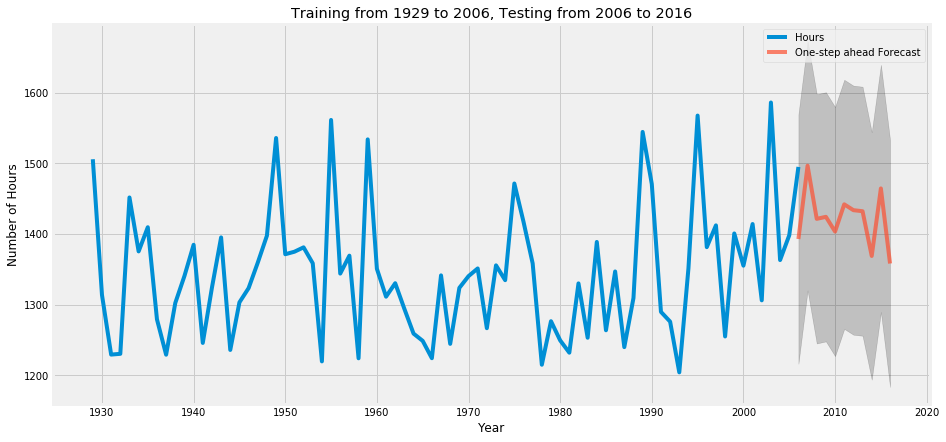

,Hours
Year,
1981-01-01,1232.037500
1982-01-01,1330.119344
1983-01-01,1253.201712
1984-01-01,1388.785632
1985-01-01,1263.784018
1986-01-01,1346.979888
1987-01-01,1239.920613
1988-01-01,1309.400786
1989-01-01,1544.493226


In [39]:
# validating forecasts from 2006 to the end date 2016

pred = results.get_prediction(start=pd.to_datetime('2006-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1929':'2006'].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1929 to 2006, Testing from 2006 to 2016')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Hours')
plt.legend()
plt.show()
df['1981':]
# observations: the predicted plot(orange) is similar to the expected plot(blue)

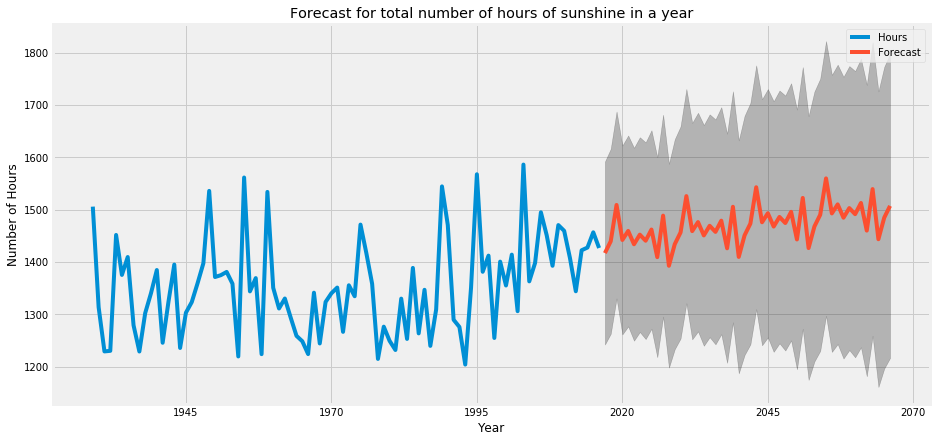

2017-01-01    1417.133813
2018-01-01    1439.628455
2019-01-01    1509.019232
2020-01-01    1442.157527
2021-01-01    1459.410129
2022-01-01    1433.985358
2023-01-01    1452.352149
2024-01-01    1440.711034
2025-01-01    1462.105043
2026-01-01    1409.373426
2027-01-01    1488.611286
2028-01-01    1392.917273
2029-01-01    1434.041314
2030-01-01    1456.535956
2031-01-01    1525.926732
2032-01-01    1459.065027
2033-01-01    1476.317630
2034-01-01    1450.892859
2035-01-01    1469.259650
2036-01-01    1457.618535
2037-01-01    1479.012544
2038-01-01    1426.280927
2039-01-01    1505.518787
2040-01-01    1409.824773
2041-01-01    1450.948815
2042-01-01    1473.443456
2043-01-01    1542.834233
2044-01-01    1475.972528
2045-01-01    1493.225130
2046-01-01    1467.800360
2047-01-01    1486.167150
2048-01-01    1474.526036
2049-01-01    1495.920045
2050-01-01    1443.188427
2051-01-01    1522.426287
2052-01-01    1426.732274
2053-01-01    1467.856315
2054-01-01    1490.350957
2055-01-01  

In [34]:
# forecasting data for future 
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Forecast for total number of hours of sunshine in a year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Hours')
plt.legend()
plt.show()
pred_uc.predicted_mean
# observations: the prediction model seems to follow the learned trend and keeps on increasing as expected

In [20]:
# Extract the predicted and true values of our time series
y_forecasted = pred_uc.predicted_mean
y_truth = df['2006-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# the results are NaN - why?

The Mean Squared Error of our forecasts is 2017-01-01 00:00:00   NaN
2018-01-01 00:00:00   NaN
2019-01-01 00:00:00   NaN
2020-01-01 00:00:00   NaN
2021-01-01 00:00:00   NaN
2022-01-01 00:00:00   NaN
2023-01-01 00:00:00   NaN
2024-01-01 00:00:00   NaN
2025-01-01 00:00:00   NaN
2026-01-01 00:00:00   NaN
2027-01-01 00:00:00   NaN
2028-01-01 00:00:00   NaN
2029-01-01 00:00:00   NaN
2030-01-01 00:00:00   NaN
2031-01-01 00:00:00   NaN
2032-01-01 00:00:00   NaN
2033-01-01 00:00:00   NaN
2034-01-01 00:00:00   NaN
2035-01-01 00:00:00   NaN
2036-01-01 00:00:00   NaN
2037-01-01 00:00:00   NaN
2038-01-01 00:00:00   NaN
2039-01-01 00:00:00   NaN
2040-01-01 00:00:00   NaN
2041-01-01 00:00:00   NaN
2042-01-01 00:00:00   NaN
2043-01-01 00:00:00   NaN
2044-01-01 00:00:00   NaN
2045-01-01 00:00:00   NaN
2046-01-01 00:00:00   NaN
2047-01-01 00:00:00   NaN
2048-01-01 00:00:00   NaN
2049-01-01 00:00:00   NaN
2050-01-01 00:00:00   NaN
2051-01-01 00:00:00   NaN
2052-01-01 00:00:00   NaN
2053-01-01 00:00:00  